In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bestmodel/kaggle/working/distilgpt2/config.json
/kaggle/input/bestmodel/kaggle/working/distilgpt2/training_args.bin
/kaggle/input/bestmodel/kaggle/working/distilgpt2/model.safetensors
/kaggle/input/bestmodel/kaggle/working/distilgpt2/generation_config.json
/kaggle/input/customer-support-on-twitter/sample.csv
/kaggle/input/customer-support-on-twitter/twcs/twcs.csv
/kaggle/input/dataset-training/eval/kaggle/working/eval/state.json
/kaggle/input/dataset-training/eval/kaggle/working/eval/dataset_info.json
/kaggle/input/dataset-training/eval/kaggle/working/eval/dataset.arrow
/kaggle/input/dataset-training/train/kaggle/working/train/state.json
/kaggle/input/dataset-training/train/kaggle/working/train/dataset_info.json
/kaggle/input/dataset-training/train/kaggle/working/train/dataset.arrow
/kaggle/input/dataset/kaggle/working/test/state.json
/kaggle/input/dataset/kaggle/working/test/dataset_info.json
/kaggle/input/dataset/kaggle/working/test/dataset.arrow


### Prepare data

In [2]:
data = pd.read_csv('/kaggle/input/customer-support-on-twitter/twcs/twcs.csv')
data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


### Preprocess data

In [3]:
import re

def preprocess_text(text):
    # Menghapus @mentions
    text = re.sub(r'@\w+', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Menghapus emoticon
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

    # Menghapus karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Menghapus karakter tertentu
    text = re.sub(r'[\^*\\~-].*', '', text)

    # Menghapus new line
    text = re.sub(r'\n', ' ', text)

    return text

data['text'] = data['text'].apply(preprocess_text)
data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,I understand. I would like to assist you. We ...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,I have sent several private messages and no o...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,Please send us a Private Message so that we c...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"Hey, we'd be happy to look into this for you....",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,wtf!? Ive been having really shitty service a...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,You have to go to and ask them to add the H...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"Sounds delicious, Sarah!",NaN,2987950.0


### Make data to Question Anwering format

In [4]:
questions = data[data['inbound']]
questions

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,I have sent several private messages and no o...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,You gonna magically change your connectivity ...,"11,13,14",15.0
...,...,...,...,...,...,...,...
2811765,2987944,823868,True,Wed Nov 22 07:43:36 +0000 2017,I am unable to do web checkin. I am gettin...,2987943,NaN
2811768,2987946,524544,True,Wed Nov 22 08:25:48 +0000 2017,Hope you are well? Does the 9.30am train from...,2987945,NaN
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,wtf!? Ive been having really shitty service a...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,You have to go to and ask them to add the H...,NaN,2812239.0


In [5]:
answers = data[data['in_response_to_tweet_id'].notna() &  (~data['inbound'])]
answers

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,I understand. I would like to assist you. We ...,2,3.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,Please send us a Private Message so that we c...,3,5.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...","5,7",8.0
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,This is saddening to hear. Please shoot us a ...,NaN,12.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,We understand your concerns and we'd like for...,12,16.0
...,...,...,...,...,...,...,...
2811764,2987943,AirAsiaSupport,False,Wed Nov 22 07:54:57 +0000 2017,"Sorry but kindly try to clear browser,cache,c...",NaN,2987944.0
2811766,139628,ArgosHelpers,False,Wed Nov 22 08:03:26 +0000 2017,Can you Dm us your order number and we can lo...,NaN,139627.0
2811767,2987945,VirginTrains,False,Wed Nov 22 08:27:34 +0000 2017,That's a Peak service. The 09:56 is the first...,NaN,2987946.0
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"Hey, we'd be happy to look into this for you....",NaN,2987948.0


In [6]:
qa = pd.merge(questions[['tweet_id', 'text', 'in_response_to_tweet_id']], answers[['text', 'in_response_to_tweet_id', 'tweet_id', 'author_id']], left_on='tweet_id', right_on='in_response_to_tweet_id')

qa.columns = ['question_id', 'question', 'in_response_to_tweet_id', 'answer', 'lol', 'answer_id', 'author_id']

qa = qa.drop('lol', axis=1)
qa

,question_id,question,in_response_to_tweet_id,answer,answer_id,author_id
0,3,I have sent several private messages and no o...,4.0,I understand. I would like to assist you. We ...,1,sprintcare
1,5,I did.,6.0,Please send us a Private Message so that we c...,4,sprintcare
2,8,is the worst customer service,NaN,"Can you please send us a private message, so ...",6,sprintcare
3,8,is the worst customer service,NaN,I would love the chance to review the account...,9,sprintcare
4,8,is the worst customer service,NaN,Hello! We never like our customers to feel li...,10,sprintcare
...,...,...,...,...,...,...
1261883,2987942,Hai #asking how many days needed to proceed c...,NaN,we have replied you via DM.Thanks,2987941,AirAsiaSupport
1261884,2987944,I am unable to do web checkin. I am gettin...,NaN,"Sorry but kindly try to clear browser,cache,c...",2987943,AirAsiaSupport
1261885,2987946,Hope you are well? Does the 9.30am train from...,NaN,That's a Peak service. The 09:56 is the first...,2987945,VirginTrains
1261886,2987948,wtf!? Ive been having really shitty service a...,NaN,"Hey, we'd be happy to look into this for you....",2987947,sprintcare


In [7]:
dont_have_answer = questions[~questions['tweet_id'].isin(qa['question_id'])]
dont_have_answer = dont_have_answer.dropna(subset=['response_tweet_id'])
dont_have_answer = dont_have_answer[dont_have_answer['tweet_id'].isin(qa['in_response_to_tweet_id'])]
dont_have_answer

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
40,46,115722,True,Tue Oct 31 22:04:29 +0000 2017,"Hello Duke, Do you have a copy of your bill? ...",42,47.0
148,234,115762,True,Tue Oct 31 05:55:08 +0000 2017,i pre ordered wwii but how do i get the code?,232,NaN
204,293,115769,True,Wed Oct 18 14:07:45 +0000 2017,Whoa! Come along with Lightrooms own Ben Warde...,292,NaN
228,318,115785,True,Tue Oct 31 20:03:55 +0000 2017,can anyone let me know when our pre orders...,311,NaN
238,328,115794,True,Tue Oct 31 21:57:43 +0000 2017,Ah maybe could help on this one,327,329.0
...,...,...,...,...,...,...,...
2811400,2987587,823760,True,Thu Nov 30 02:32:10 +0000 2017,You even tried to charge us when THE WRONG TE...,2987586,2987588.0
2811415,2987600,665118,True,Wed Nov 22 01:25:59 +0000 2017,Literally called customer support for them to...,2987599,NaN
2811582,2987763,823812,True,Thu Nov 30 00:40:58 +0000 2017,"I need an everything bagel and like, a Target ...",2987762,NaN
2811620,2987799,630312,True,Tue Oct 31 21:32:46 +0000 2017,Icing on the cake was flight was 1/2 full. If...,2987798,2987800.0


In [8]:
new_qa = pd.merge(dont_have_answer[['tweet_id', 'text', 'in_response_to_tweet_id']], qa[['answer', 'in_response_to_tweet_id', 'answer_id', 'author_id']], left_on='tweet_id', right_on='in_response_to_tweet_id')

new_qa.columns = ['question_id', 'question', 'in_response_to_tweet_id', 'answer', 'lol', 'answer_id', 'author_id']

new_qa = new_qa.drop('lol', axis=1)
new_qa

,question_id,question,in_response_to_tweet_id,answer,answer_id,author_id
0,46,"Hello Duke, Do you have a copy of your bill? ...",47.0,Please follow and DM us so that we can look i...,40,VerizonSupport
1,234,i pre ordered wwii but how do i get the code?,NaN,"Hello there, I apologize for the delay. Can y...",231,ATVIAssist
2,293,Whoa! Come along with Lightrooms own Ben Warde...,NaN,"Hi Duncan, please update Lightroom to 6.13 fr...",291,AdobeCare
3,318,can anyone let me know when our pre orders...,NaN,Hi there! We'd recommend reaching out to the ...,309,XboxSupport
4,328,Ah maybe could help on this one,329.0,Hi. Emergency services are dealing with an i...,326,nationalrailenq
...,...,...,...,...,...,...
89995,2987587,You even tried to charge us when THE WRONG TE...,2987588.0,"Hello, We are able to look into your service ...",2987585,comcastcares
89996,2987600,Literally called customer support for them to...,NaN,I apologize for the experience you had. I'd l...,2987598,Ask_WellsFargo
89997,2987763,"I need an everything bagel and like, a Target ...",NaN,Thanks for reaching out to us. We're here to ...,2987761,AskTarget
89998,2987799,Icing on the cake was flight was 1/2 full. If...,2987800.0,"We're sorry to hear of your experience, Carol...",2987797,SouthwestAir


In [9]:
qa = pd.concat([qa, new_qa], ignore_index=True)

In [10]:
qa = qa.drop(['in_response_to_tweet_id', 'question_id', 'answer_id'], axis=1)
qa

,question,answer,author_id
0,I have sent several private messages and no o...,I understand. I would like to assist you. We ...,sprintcare
1,I did.,Please send us a Private Message so that we c...,sprintcare
2,is the worst customer service,"Can you please send us a private message, so ...",sprintcare
3,is the worst customer service,I would love the chance to review the account...,sprintcare
4,is the worst customer service,Hello! We never like our customers to feel li...,sprintcare
...,...,...,...
1351883,You even tried to charge us when THE WRONG TE...,"Hello, We are able to look into your service ...",comcastcares
1351884,Literally called customer support for them to...,I apologize for the experience you had. I'd l...,Ask_WellsFargo
1351885,"I need an everything bagel and like, a Target ...",Thanks for reaching out to us. We're here to ...,AskTarget
1351886,Icing on the cake was flight was 1/2 full. If...,"We're sorry to hear of your experience, Carol...",SouthwestAir


In [11]:
qa['word_count'] = qa['answer'].apply(lambda x:len(x.split()))
qa

,question,answer,author_id,word_count
0,I have sent several private messages and no o...,I understand. I would like to assist you. We ...,sprintcare,22
1,I did.,Please send us a Private Message so that we c...,sprintcare,22
2,is the worst customer service,"Can you please send us a private message, so ...",sprintcare,18
3,is the worst customer service,I would love the chance to review the account...,sprintcare,12
4,is the worst customer service,Hello! We never like our customers to feel li...,sprintcare,13
...,...,...,...,...
1351883,You even tried to charge us when THE WRONG TE...,"Hello, We are able to look into your service ...",comcastcares,23
1351884,Literally called customer support for them to...,I apologize for the experience you had. I'd l...,Ask_WellsFargo,34
1351885,"I need an everything bagel and like, a Target ...",Thanks for reaching out to us. We're here to ...,AskTarget,35
1351886,Icing on the cake was flight was 1/2 full. If...,"We're sorry to hear of your experience, Carol...",SouthwestAir,20


### Visualize data base on word count

In [ ]:
import matplotlib.pyplot as plt

# Buat histogram dari 'word_count'
plt.figure(figsize=(10,6))
plt.hist(qa['word_count'], bins=20, alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count of Answers')
plt.show()


### Count how many row the word appear

In [ ]:
token_map_answer = {}
for tokens in qa['answer'].to_list():
  tokens = tokens.split()
  unique_tokens = set(tokens)  # Mengubah list tokens menjadi set untuk menghilangkan duplikat
  for token in unique_tokens:
    if token in token_map_answer:
      token_map_answer[token] += 1
    else:
      token_map_answer[token] = 1

### Choose the data to do fine tuning but still need to choose 200000 row

In [12]:
qa = qa[qa['question'].apply(len) >= 5]
qa = qa[qa['answer'].apply(len) >= 10]
qa = qa.drop_duplicates(subset=['question'])
qa = qa.drop_duplicates(subset=['answer'])
dm_indices = qa[qa['answer'].str.contains('DM')].index

# Pilih 180000 indeks secara acak
drop_indices = dm_indices.to_series().sample(n=180000, random_state=1)

# Hapus baris-baris tersebut dari DataFrame
qa = qa.drop(drop_indices)
qa = qa.reset_index(drop=True)
qa

,question,answer,author_id,word_count
0,I have sent several private messages and no o...,I understand. I would like to assist you. We ...,sprintcare,22
1,I did.,Please send us a Private Message so that we c...,sprintcare,22
2,is the worst customer service,"Can you please send us a private message, so ...",sprintcare,18
3,You gonna magically change your connectivity ...,This is saddening to hear. Please shoot us a ...,sprintcare,19
4,Since I signed up with you....Since day 1,We understand your concerns and we'd like for...,sprintcare,23
...,...,...,...,...
734814,i ternd off my ps4 and it just says preparing...,Frozen on message: Preparing to turn off. Dis...,AskPlayStation,21
734815,# Dear Idea Team My Bill Amount 1241 rs but ...,We would like to inform you that full and fin...,idea_cares,23
734816,when are yall dropping season 3 of rick and m...,Sorry for the delayed reply! We don't have a ...,hulu_support,26
734817,via,(Amazon RI,AmazonHelp,2


In [ ]:
qa = qa[qa['question'].apply(len) >= 5]
qa = qa[qa['answer'].apply(len) >= 10]
qa = qa.drop_duplicates(subset=['question'])
qa = qa.drop_duplicates(subset=['answer'])
dm_indices = qa[qa['answer'].str.contains('DM')].index

# Pilih 180000 indeks secara acak
drop_indices = dm_indices.to_series().sample(n=180000, random_state=1)

# Hapus baris-baris tersebut dari DataFrame
qa = qa.drop(drop_indices)
qa = qa.reset_index(drop=True)
qa

### Get 200000 samples data but there is no dominant author id amount

In [13]:

def get_samples(qa: pd.DataFrame, sample_size: int = 40000) -> pd.DataFrame:
    bins = [(3, 10), (11, 20), (21, 30), (31, 40), (41, float('inf'))]
    samples = []

    for bin in bins:
        bin_df = qa[(qa['word_count'] >= bin[0]) & (qa['word_count'] <= bin[1])]
        author_ids = bin_df['author_id'].unique()

        author_samples = []
        for author_id in author_ids:
            author_df = bin_df[bin_df['author_id'] == author_id]
            author_sample = author_df.sample(min(len(author_df), sample_size // len(author_ids)), replace=True)
            author_samples.append(author_sample)

        bin_samples = pd.concat(author_samples).sample(sample_size, replace=True)
        samples.append(bin_samples)

    return pd.concat(samples)


In [14]:
n = get_samples(qa)
n = n.reset_index(drop=True)
n

,question,answer,author_id,word_count
0,you should make it so that I can block artist...,"Hey, thanks for the feedback",SpotifyCares,5
1,I don't have internet connection after using ...,"Hi Nimrod , kindly provide a contact number",Safaricom_Care,8
2,what's good w the national taco day specials ...,Hey Laura. We're celebrating with a Taco Day ...,TacoBellTeam,10
3,why is Tesco Direct website such dogshit?,What issue are you having Paula?,Tesco,6
4,"hi, if i have baby how can I request baby cha...",Find out more info about Uber Car Seat here;,Uber_Support,9
...,...,...,...,...
199995,app down? Website down? I've just spent an ho...,"Hello Ben, I am sorry you are having trouble ...",Tesco,45
199996,Does my se2417hg monitor not adjust up/down? ...,While we understand this can be of some incon...,DellCares,52
199997,sudah beli tiket airline hr ini melalui trave...,"Hi, mohon maaf atas kelewatan kami. Bagi temp...",AirAsiaSupport,42
199998,Have been down this route. It was who charg...,"Hi Douglas, we're sorry to hear you're having...",British_Airways,46


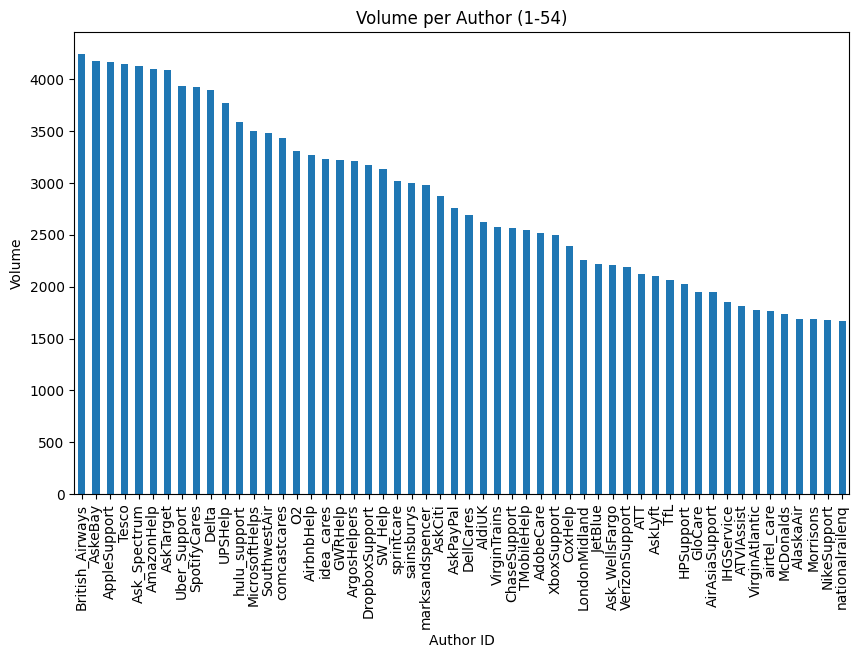

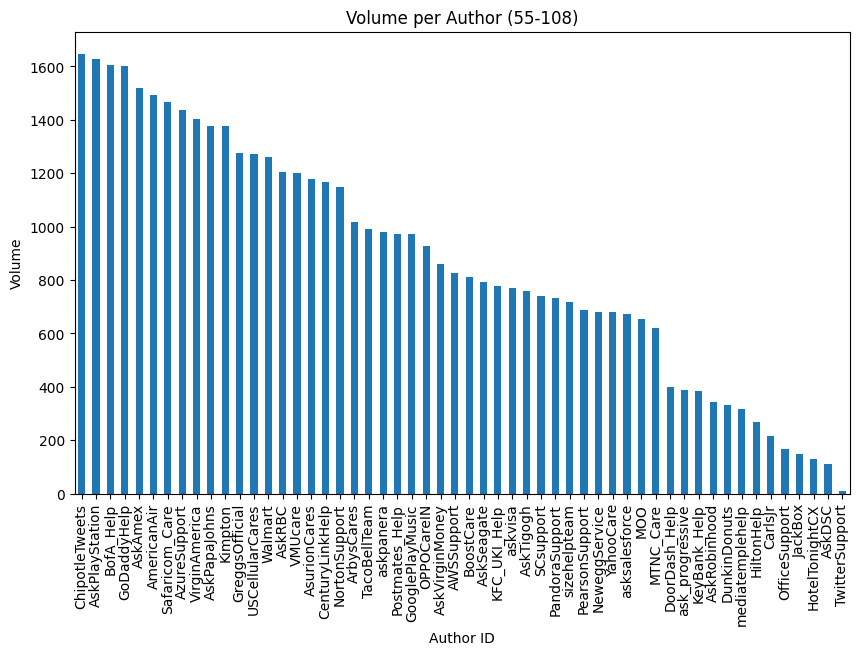

In [15]:
import matplotlib.pyplot as plt

# Hitung volume untuk setiap 'author_id'
author_counts = n['author_id'].value_counts()

# Urutkan 'author_id' berdasarkan volume
sorted_author_counts = author_counts.sort_values(ascending=False)

# Pisahkan data menjadi dua bagian
first_half = sorted_author_counts[:54]
second_half = sorted_author_counts[54:]

# Buat plot untuk bagian pertama
plt.figure(figsize=(10,6))
first_half.plot(kind='bar')
plt.title('Volume per Author (1-54)')
plt.xlabel('Author ID')
plt.ylabel('Volume')
plt.show()

# Buat plot untuk bagian kedua
plt.figure(figsize=(10,6))
second_half.plot(kind='bar')
plt.title('Volume per Author (55-108)')
plt.xlabel('Author ID')
plt.ylabel('Volume')
plt.show()


In [ ]:
def take_up_to_250_rows(group):
    return group.sample(n=min(250, len(group)), random_state=1)

# Kelompokkan berdasarkan 'author_id' dan ambil sampai 250 baris acak dari setiap grup
qa = qa.groupby('author_id').apply(take_up_to_250_rows)

# Reset index
qa = qa.reset_index(drop=True)
qa

In [ ]:
apple = qa[qa['author_id']=='AppleSupport'].sample(n=25000)
apple = apple.reset_index(drop=True)
qa = qa[qa['author_id']=='AppleSupport'].sample(n=25000)
qa = qa.reset_index(drop=True)

In [ ]:
apple

In [ ]:
# Word Count
token_map_answer = {}
for tokens in qa['answer'].to_list():
  tokens = tokens.split()
  unique_tokens = set(tokens)  # Mengubah list tokens menjadi set untuk menghilangkan duplikat
  for token in unique_tokens:
    if token in token_map_answer:
      token_map_answer[token] += 1
    else:
      token_map_answer[token] = 1
word_count_list_answer = [(token, count) for token, count in token_map_answer.items()]

print(word_count_list_answer[:10])
print('============')
sorted_word_count_answer = sorted(token_map_answer.items(), key=lambda x: x[1], reverse=True)

top_200_tokens_answer = sorted_word_count_answer[:100]
print(top_200_tokens_answer)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from transformers import PreTrainedModel
from transformers import pipeline, set_seed, TextGenerationPipeline
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.tokenization_utils_base import BatchEncoding
from transformers import DataCollatorForLanguageModeling, DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import set_seed
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from datasets.iterable_dataset import IterableDataset
from torch import nn
from torch import Tensor
from typing import List, Dict, Any
import pandas as pd
import re
import json
import multiprocessing
import torch

model_id: str = 't5-base' # you can also try: distilgpt2 gpt2
num_train_epochs: int = 1
instruction_format: str = (
    "Below is an instruction that describes a task. "
    "Write a response that appropriately completes the request.\n"
    "\n"
    "### Question:\n"
    "{question}"
    "\n\n"
    "### Answer:\n"
    "{answer}"
)
device: torch.device = torch.device("cuda") \
  if torch.cuda.is_available() else torch.device("cpu")
device

2024-05-08 02:41:37.366343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 02:41:37.366471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 02:41:37.501966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cuda')

### This one for testing

In [3]:
test_dataset: Dataset = load_from_disk('/kaggle/input/dataset/kaggle/working/test')
train_dataset: Dataset = load_from_disk('/kaggle/input/dataset-training/train/kaggle/working/train')
eval_dataset: Dataset = load_from_disk('/kaggle/input/dataset-training/eval/kaggle/working/eval')

train_dataset

Dataset({
    features: ['author_id', 'input_ids', 'attention_mask'],
    num_rows: 198000
})

### decode the input_ids to word

In [5]:
tokenizer: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [21]:
tokenizer: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained('distilgpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
from tqdm import tqdm

test_question_answer_2 = []
for input_id in test_dataset['input_ids']:
    test_question_answer_2.append(tokenizer.decode(input_id, skip_special_tokens=True))
train_question_answer_2 = []
for input_id in tqdm(train_dataset['input_ids']):
    train_question_answer_2.append(tokenizer.decode(input_id, skip_special_tokens=True))
eval_question_answer_2 = []
for input_id in eval_dataset['input_ids']:
    eval_question_answer_2.append(tokenizer.decode(input_id, skip_special_tokens=True))

100%|██████████| 198000/198000 [02:51<00:00, 1154.98it/s]


In [23]:
print(train_question_answer_2[90])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Question:
per second bill live EU ireland region

### Answer:
 Hi, Anthony. I can confirm that Per


In [14]:
from tqdm import tqdm

test_question_answer = []
for input_id in test_dataset['input_ids']:
    test_question_answer.append(tokenizer.decode(input_id, skip_special_tokens=True))
train_question_answer = []
for input_id in tqdm(train_dataset['input_ids']):
    train_question_answer.append(tokenizer.decode(input_id, skip_special_tokens=True))
eval_question_answer = []
for input_id in eval_dataset['input_ids']:
    eval_question_answer.append(tokenizer.decode(input_id, skip_special_tokens=True))

100%|██████████| 198000/198000 [02:50<00:00, 1158.69it/s]


In [20]:
print(train_question_answer[90])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Question:
per second bill live EU ireland region

### Answer:
 Hi, Anthony. I can confirm that Per


### Take question and answer from instruction format

In [7]:
def find_answer_index(lines):
    for i in range(3, len(lines)):
        if (lines[i]=='### Answer:'):
            return i

In [8]:
def get_question_answer(text):
    lines = text.split('\n')
    quest = ''
    ans = ''
    answer_index = find_answer_index(lines)
    for i in range(3, answer_index-1):
        quest = quest + lines[i]
    for i in range(answer_index + 1, len(lines)):
        ans = ans + lines[i]
    return (quest,ans)
        
    

In [24]:
train_question_list = []
train_answer_list = []
for i in tqdm(range(len(train_question_answer))):
    try:
        train_question_list.append(get_question_answer(train_question_answer[i])[0])
        train_answer_list.append(get_question_answer(train_question_answer[i])[1])
    except:
        print(train_question_answer[i])

test_question_list = []
test_answer_list = []
for i in range(len(test_question_answer)):
    try:
        test_question_list.append(get_question_answer(test_question_answer[i])[0])
        test_answer_list.append(get_question_answer(test_question_answer[i])[1])
    except:
        print(test_question_answer[i])
eval_answer_list = []
eval_question_list = []
for i in range(len(eval_question_answer)):
    try:
        eval_question_list.append(get_question_answer(eval_question_answer[i])[0])
        eval_answer_list.append(get_question_answer(eval_question_answer[i])[1])
    except:
        print(eval_question_answer[i])


100%|██████████| 198000/198000 [00:01<00:00, 148076.57it/s]


In [31]:
# Misalkan kita memiliki list berikut
train_data = {'question': train_question_list, 'answer': train_answer_list}
test_data = {'question': test_question_list, 'answer': test_answer_list}
eval_data = {'question': eval_question_list, 'answer': eval_answer_list}

# Mengubah list menjadi Dataset
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)
eval_dataset = Dataset.from_dict(eval_data)

print(train_dataset)
print(test_dataset)
print(eval_dataset)


Dataset({
    features: ['question', 'answer'],
    num_rows: 198000
})
Dataset({
    features: ['question', 'answer'],
    num_rows: 1000
})
Dataset({
    features: ['question', 'answer'],
    num_rows: 1000
})


In [25]:
print(len(train_question_list))
print(len(train_answer_list))

198000
198000


In [28]:
train_answer_list[50]

" Hi. We'd like to help with your recurring transfer. "

In [10]:
print(len(test_question_list))
print(len(test_answer_list))

1000
1000


In [11]:
print(test_question_list[0])

safari download button render shift leav rest page load might comment box


### This one for training

In [32]:
tokenizer: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model: nn.Module = AutoModelForSeq2SeqLM.from_pretrained(model_id)
print(f"model: {model}")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model: T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropou

In [17]:
from typing import List, Dict, Any, Set, Tuple

In [18]:
# Tokenize
tokenizer_pattern: str = r"\b\w[\w']*\b"
example_passage_en = "Thank you. DM me your name, address, contact details, and phone number associated with your account. Thanks-Emir. ^BG  *HDG  *HDG  ^LC  *HDG *Mobile *Mobile * *Regards *"
def tokenize_text_en(text: str, tokenizer_pattern: str) -> List[str]:
  tokens: List[str] = re.findall(tokenizer_pattern, text)
  return tokens
example_tokens_en: List[str] = tokenize_text_en(
  text = example_passage_en,
  tokenizer_pattern = tokenizer_pattern,
)
print(f"example of tokenized text: {example_tokens_en}")

example of tokenized text: ['Thank', 'you', 'DM', 'me', 'your', 'name', 'address', 'contact', 'details', 'and', 'phone', 'number', 'associated', 'with', 'your', 'account', 'Thanks', 'Emir', 'BG', 'HDG', 'HDG', 'LC', 'HDG', 'Mobile', 'Mobile', 'Regards']


In [19]:
import spacy
# Install packages as needed
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
# Lemmatize
nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens_en(tokens: List[str], nlp) -> List[str]:
    example_lemmatized_en = []

    for doc in nlp.pipe(tokens):
        tok = [token.lemma_ for token in doc]
        example_lemmatized_en.extend(tok)

    return example_lemmatized_en

example_lemmatized_en: List[str] = lemmatize_tokens_en(
  tokens = example_tokens_en,
  nlp = nlp,
)
print(f"example of tokens before lemmatization: {example_tokens_en}")
print(f"example of tokens after lemmatization:  {example_lemmatized_en}")

example of tokens before lemmatization: ['Thank', 'you', 'DM', 'me', 'your', 'name', 'address', 'contact', 'details', 'and', 'phone', 'number', 'associated', 'with', 'your', 'account', 'Thanks', 'Emir', 'BG', 'HDG', 'HDG', 'LC', 'HDG', 'Mobile', 'Mobile', 'Regards']
example of tokens after lemmatization:  ['thank', 'you', 'dm', 'I', 'your', 'name', 'address', 'contact', 'detail', 'and', 'phone', 'number', 'associate', 'with', 'your', 'account', 'thank', 'Emir', 'BG', 'HDG', 'HDG', 'lc', 'HDG', 'mobile', 'mobile', 'regard']


In [21]:
# Stemming
import nltk
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens_en(tokens: List[str], stemmer: PorterStemmer) -> List[str]:
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

example_tokens_after_stemming_en: List[str] = stem_tokens_en(
  tokens = example_lemmatized_en,
  stemmer = stemmer,
)
print(f"example of tokens before stemming: {example_lemmatized_en}")
print(f"example of tokens after stemming:  {example_tokens_after_stemming_en}")

example of tokens before stemming: ['thank', 'you', 'dm', 'I', 'your', 'name', 'address', 'contact', 'detail', 'and', 'phone', 'number', 'associate', 'with', 'your', 'account', 'thank', 'Emir', 'BG', 'HDG', 'HDG', 'lc', 'HDG', 'mobile', 'mobile', 'regard']
example of tokens after stemming:  ['thank', 'you', 'dm', 'I', 'your', 'name', 'address', 'contact', 'detail', 'and', 'phone', 'number', 'associ', 'with', 'your', 'account', 'thank', 'emir', 'BG', 'hdg', 'hdg', 'lc', 'hdg', 'mobil', 'mobil', 'regard']


In [22]:
# Stop Words Removal
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk_stop_words_list: List[str] = stopwords.words('english')
nltk_stop_words_set: Set[str] = set(nltk_stop_words_list)

def remove_stop_words_en(tokens: List[str], stop_words: Dict[str, Any]) -> List[str]:
  tokens_without_stop_words: List[str] = [
      token
      for token in tokens
      if token not in stop_words
  ]
  return tokens_without_stop_words

example_tokens_without_stop_words_en: List[str] = remove_stop_words_en(
  tokens = example_tokens_after_stemming_en,
  stop_words = nltk_stop_words_set,
)

print(f"stop words from NLTK: {nltk_stop_words_set}\n")
print(f"example of tokens with stop words (before):   {example_tokens_after_stemming_en}")
print(f"example of tokens without stop words (after): {example_tokens_without_stop_words_en}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
stop words from NLTK: {"should've", 'during', 'until', 'her', 'm', 'theirs', 'of', 'if', 'all', 'doing', 'what', 'yours', 'such', 'yourself', "it's", 'from', 'own', 'd', 'shan', 'each', 'nor', 're', 'she', 'mightn', 'then', "doesn't", 'so', 'him', 'haven', 'how', 'had', 'this', "weren't", "hasn't", 'them', "you're", 'hers', 'he', 'itself', 'above', 'with', 'his', 'an', 'wouldn', 'your', "wouldn't", 'having', 'before', 'you', 'only', "hadn't", 'i', 'my', "won't", 'o', 'does', 'because', 'below', 'who', 'both', 'more', 'should', 'will', 'hasn', "you've", 'are', 's', 'aren', 'for', 'same', 'on', 'but', 'can', 'in', 'has', 'it', 'ain', 'under', 'isn', 'did', 'any', 'now', 'doesn', 'not', 'as', 'be', "aren't", 'where', 'over', 'there', "needn't", "she's", 'further', 'our', 'why', 'when', 'wasn', 'no', 'down', "haven't", "isn't", "you'll", 'or', 'few', 'didn', 'here', '

In [23]:
def join_words_en(tokens: List[str]) -> str:
    words: str = ' '.join(tokens)
    return words

example_words_without_stop_words_en: List[str] = join_words_en(
  tokens = example_tokens_without_stop_words_en,
)

print(f"stop words from NLTK: {nltk_stop_words_set}\n")
print(f"example of tokens with stop words (before):   {example_tokens_without_stop_words_en}")
print(f"example of tokens without stop words (after): {example_words_without_stop_words_en}")

stop words from NLTK: {"should've", 'during', 'until', 'her', 'm', 'theirs', 'of', 'if', 'all', 'doing', 'what', 'yours', 'such', 'yourself', "it's", 'from', 'own', 'd', 'shan', 'each', 'nor', 're', 'she', 'mightn', 'then', "doesn't", 'so', 'him', 'haven', 'how', 'had', 'this', "weren't", "hasn't", 'them', "you're", 'hers', 'he', 'itself', 'above', 'with', 'his', 'an', 'wouldn', 'your', "wouldn't", 'having', 'before', 'you', 'only', "hadn't", 'i', 'my', "won't", 'o', 'does', 'because', 'below', 'who', 'both', 'more', 'should', 'will', 'hasn', "you've", 'are', 's', 'aren', 'for', 'same', 'on', 'but', 'can', 'in', 'has', 'it', 'ain', 'under', 'isn', 'did', 'any', 'now', 'doesn', 'not', 'as', 'be', "aren't", 'where', 'over', 'there', "needn't", "she's", 'further', 'our', 'why', 'when', 'wasn', 'no', 'down', "haven't", "isn't", "you'll", 'or', 'few', 'didn', 'here', 'too', 'needn', 'other', 'again', 'won', 'into', 'yourselves', 'out', 'mustn', 'their', 'that', 'll', "mustn't", 'have', 've'

In [ ]:
# Define your preprocessing pipeline as a function
def preprocess_text_into_tokens_en(text: str,
                                   stemmer: PorterStemmer,
                                   tokenizer_pattern: str,
                                   nlp) -> str:
  tokens: List[str] = tokenize_text_en(
    text = text,
    tokenizer_pattern = tokenizer_pattern,
  )
  tokens: List[str] = lemmatize_tokens_en(
    tokens = tokens,
    nlp = nlp,
  )
  tokens: List[str] = stem_tokens_en(
    tokens = tokens,
    stemmer = stemmer,
  )
  tokens: List[str] = remove_stop_words_en(
    tokens = tokens,
    stop_words = nltk_stop_words_set,
  )
  words: str = join_words_en(
      tokens = tokens,
  )
  return words
dataset_raw: Dataset = Dataset.from_pandas(n)
print(f"dataset_raw: {dataset_raw}")
print(f"example raw row: {json.dumps(dataset_raw[0], indent=2)}")
# Apply preprocess to all data
dataset_preprocessed_en: Dataset = dataset_raw.map(
  lambda row: dict(
    question = preprocess_text_into_tokens_en(
      text = row['question'],
      stemmer = stemmer,
      tokenizer_pattern = tokenizer_pattern,
      nlp = nlp,
    ),
  ),
  num_proc = (2),
)

print(f"preprocessed dataset: {dataset_preprocessed_en}")
print(f"example preprocessed row: {json.dumps(dataset_preprocessed_en[0], indent=2)}")

In [ ]:
print(3)

In [ ]:
print(3)

In [26]:

# Specify the size of your evaluation set. For example, 0.1 means 10% of the data will be used for evaluation.
eval_size = 0.005

# Calculate the number of samples in the evaluation set
num_eval_samples = int(eval_size * len(dataset_preprocessed_en))
num_test_samples = len(dataset_preprocessed_en) - int(eval_size * len(dataset_preprocessed_en))

# Split the dataset
dataset_dict = DatasetDict({
    'test' : dataset_preprocessed_en.select(range(num_test_samples, len(dataset_preprocessed_en))),
    'train': dataset_preprocessed_en.select(range(num_eval_samples, num_test_samples)),
    'eval': dataset_preprocessed_en.select(range(num_eval_samples))
})

print(f"Number of samples in the training set: {len(dataset_dict['train'])}")
print(f"Number of samples in the evaluation set: {len(dataset_dict['eval'])}")
print(f"Number of samples in the test set: {len(dataset_dict['test'])}")


Number of samples in the training set: 198000
Number of samples in the evaluation set: 1000
Number of samples in the test set: 1000


In [27]:
question_list = dataset_dict['test']['question']
answer_list = dataset_dict['test']['answer']
print(f'pertanyaan: {question_list[0]}')
print(f'jawaban: {answer_list[0]}')

pertanyaan: moment find littl dropbox actual care custom servic activ choos steal 120 dropboxtheft
jawaban:  Hi there, sorry to hear of any negative experiences you may have had. Wed be happy to follow up and assist in any way we can, do you have any ticket IDs as reference to any of your support submissions? Thanks in advance!


In [33]:
print('for seq2seq')
def tokenize_row(row: Dict[str, Any]) -> Dict[str, Any]:
    # Misalkan 'text' adalah teks sumber dan 'target' adalah teks target
    encoding = tokenizer(row['question'], truncation=True, padding='max_length', max_length=64)
    # Anda perlu menambahkan 'labels' ke dalam encoding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(row['answer'], truncation=True, padding='max_length', max_length=64)['input_ids']
    encoding['labels'] = labels
    return encoding

dataset_preprocessed_train: Dataset = train_dataset.map(
    tokenize_row,
    remove_columns=['question', 'answer'],  # Anda mungkin perlu menghapus kolom 'target' juga
    num_proc = (2),
)
dataset_preprocessed_eval: Dataset = eval_dataset.map(
    tokenize_row,
    remove_columns=['question', 'answer'],  # Anda mungkin perlu menghapus kolom 'target' juga

)
dataset_preprocessed_test: Dataset = test_dataset.map(
    tokenize_row,
    remove_columns=['question', 'answer'],  # Anda mungkin perlu menghapus kolom 'target' juga
)
dataset_preprocessed_train

for seq2seq
   

#0:   0%|          | 0/99000 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#1:   0%|          | 0/99000 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?ex/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 198000
})

In [ ]:
dataset_dict['train']: Dataset = dataset_dict['train'].map(
    lambda row: dict(text=instruction_format.format(
        **row
    )),
    remove_columns=['question', 'answer', 'word_count'],
    num_proc = (multiprocessing.cpu_count()),
)
dataset_dict['test']: Dataset = dataset_dict['test'].map(
    lambda row: dict(text=instruction_format.format(
        **row
    )),
    remove_columns=['question', 'answer', 'word_count'],
)
dataset_dict['eval']: Dataset = dataset_dict['eval'].map(
    lambda row: dict(text=instruction_format.format(
        **row
    )),
    remove_columns=['question', 'answer', 'word_count'],
)
print(f"dataset_text: {dataset_dict['eval']}")
print(f"example text: \n {dataset_dict['eval'][3]['text']}")
print(f"example text: \n {dataset_dict['eval'][13]['text']}")

In [ ]:
def tokenize_row(row: Dict[str, Any]) -> Dict[str, Any]:
  return tokenizer(row['text'])

dataset_preprocessed_train: Dataset = dataset_dict['train'].map(
    tokenize_row,
    remove_columns=['text'],  # Anda mungkin perlu menghapus kolom 'target' juga
    num_proc = (multiprocessing.cpu_count()),
)
dataset_preprocessed_eval: Dataset = dataset_dict['eval'].map(
    tokenize_row,
    remove_columns=['text'],  # Anda mungkin perlu menghapus kolom 'target' juga
    
)
dataset_preprocessed_test: Dataset = dataset_dict['test'].map(
    tokenize_row,
    remove_columns=['text'],  # Anda mungkin perlu menghapus kolom 'target' juga
    
)

dataset_preprocessed_train

In [34]:
dataset_preprocessed_test.save_to_disk('test')

In [35]:
dataset_preprocessed_train.save_to_disk('train')

In [36]:
dataset_preprocessed_eval.save_to_disk('eval')

In [37]:
!zip -r /kaggle/working/train.zip /kaggle/working/train
!zip -r /kaggle/working/test.zip /kaggle/working/test
!zip -r /kaggle/working/eval.zip /kaggle/working/eval

  adding: kaggle/working/train/ (stored 0%)
  adding: kaggle/working/train/dataset.arrow (deflated 87%)
  adding: kaggle/working/train/dataset_info.json (deflated 71%)
  adding: kaggle/working/train/state.json (deflated 42%)
  adding: kaggle/working/test/ (stored 0%)
  adding: kaggle/working/test/dataset.arrow (deflated 83%)
  adding: kaggle/working/test/dataset_info.json (deflated 71%)
  adding: kaggle/working/test/state.json (deflated 40%)
  adding: kaggle/working/eval/ (stored 0%)
  adding: kaggle/working/eval/dataset.arrow (deflated 92%)
  adding: kaggle/working/eval/dataset_info.json (deflated 71%)
  adding: kaggle/working/eval/state.json (deflated 40%)


In [38]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [39]:
print('for seq2seq')
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir=f"{model_id}-stackexchange",
    per_device_train_batch_size=4, # important, to prevent GPU OOM
    num_train_epochs=3,
    push_to_hub=False,
    save_strategy='no',
    learning_rate=2e-4,
    adam_beta1=0.8,
    logging_steps=2000,
)
# for more args, visit:
# https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_preprocessed_train,
    eval_dataset=dataset_preprocessed_eval,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


for seq2seq


Step,Training Loss
2000,1.653000
4000,1.511500
6000,1.469100
8000,1.422800
10000,1.392400
12000,1.353900
14000,1.329600
16000,1.304700
18000,1.257700
20000,1.261300


KeyboardInterrupt: 

In [8]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir=f"{model_id}-stackexchange",
    per_device_train_batch_size=4, # important, to prevent GPU OOM
    num_train_epochs=3,
    push_to_hub=False,
    save_strategy='no',
    learning_rate=2e-4,
    adam_beta1=0.8,
    logging_steps=2000,
)
# for more args, visit:
# https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
2000,2.563600
4000,2.352800
6000,2.249700
8000,2.189300
10000,2.132800
12000,2.089300
14000,2.052000
16000,1.993400
18000,1.970800
20000,1.933000


TrainOutput(global_step=148500, training_loss=1.3739654884209938, metrics={'train_runtime': 13256.632, 'train_samples_per_second': 44.808, 'train_steps_per_second': 11.202, 'total_flos': 3.0005384758272e+16, 'train_loss': 1.3739654884209938, 'epoch': 3.0})

In [13]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.37759727239608765,
 'eval_runtime': 6.2416,
 'eval_samples_per_second': 160.215,
 'eval_steps_per_second': 20.027,
 'epoch': 3.0}

In [ ]:
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
set_seed(87)
def generate_text_sampling_top_k_50(
    input_prompt: str,
    min_length: str = 3,
    max_length: int = 500,
    top_k: int = 50,
  ) -> str:
  input_prompt: str = instruction_format.format(
      question=input_prompt,
      answer='',
  )
  encoded_input: BatchEncoding = tokenizer(input_prompt, return_tensors='pt').to(device)
  sampling_output_tensor: Tensor = model.generate(
      **encoded_input,
      min_length=min_length,
      max_length=max_length,
      do_sample=True,
      top_k=top_k,
  )
  sampling_output_text: str = tokenizer.batch_decode(sampling_output_tensor, skip_special_tokens=True)[0]
  answer = preprocess_answer(sampling_output_text)
  return answer



In [11]:
set_seed(87)
def generate_text_sampling_top_k_10(
    input_prompt: str,
    min_length: str = 3,
    max_length: int = 256,
    top_k: int = 10,
  ) -> str:
  input_prompt: str = instruction_format.format(
      question=input_prompt,
      answer='',
  )
  encoded_input: BatchEncoding = tokenizer(input_prompt, return_tensors='pt').to(device)
  sampling_output_tensor: Tensor = model.generate(
      **encoded_input,
      min_length=min_length,
      max_length=max_length,
      pad_token_id=50256,
      do_sample=True,
      top_k=top_k,
  )
  sampling_output_text: str = tokenizer.batch_decode(sampling_output_tensor, skip_special_tokens=True)[0]
  answer = preprocess_answer(sampling_output_text)
  return answer



In [ ]:
print(generate_text_sampling_top_k(input_prompt=question_list[33]))

In [ ]:
print(3)

In [25]:
set_seed(87)
def generate_text_sampling_top_p_nucleus_92(
    input_prompt: str,
    min_length: int = 3,
    max_length: int =256,
    top_p: float = 0.92,
  ) -> str:
  input_prompt: str = instruction_format.format(
      question=input_prompt,
      answer='',
  )
  encoded_input: BatchEncoding = tokenizer(input_prompt, return_tensors='pt').to(device)
  sampling_output_tensor: Tensor = model.generate(
      **encoded_input,
      min_length=min_length,
      max_length=max_length,
      do_sample=True,
      pad_token_id=50256,
      top_p=top_p,
      top_k=0,
  )
  sampling_output_text: str = tokenizer.batch_decode(sampling_output_tensor, skip_special_tokens=True)[0]
  answer = preprocess_answer(sampling_output_text)
  return answer


In [14]:
def preprocess_answer(text):
  split_output = text.split('### Answer:')
  answer_split = split_output[1].split(' ')
  answer = ''
  index=0
  for i in answer_split:
      if i!='':
          index+=1
      if index > 2 and i=='':
          break
      else:
          answer = answer+i+' '
  answer = answer.split()
  answer = ' '.join(answer)
  return answer

### This one for testing

In [13]:
tokenizer: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token
model: nn.Module = AutoModelForCausalLM.from_pretrained('/kaggle/input/bestmodel/kaggle/working/distilgpt2')
model.to(device)
print(f"model: {model}")


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
set_seed(87)
def generate_text_sampling_top_p_nucleus_22(
    input_prompt: str,
    min_length: int = 3,
    max_length: int =256,
    top_p: float = 0.22,
  ) -> str:
  input_prompt: str = instruction_format.format(
      question=input_prompt,
      answer='',
  )
  encoded_input: BatchEncoding = tokenizer(input_prompt, return_tensors='pt').to(device)
  sampling_output_tensor: Tensor = model.generate(
      **encoded_input,
      min_length=min_length,
      max_length=max_length,
      pad_token_id=50256,
      do_sample=True,
      top_p=top_p,
      top_k=0,
  )
  sampling_output_text: str = tokenizer.batch_decode(sampling_output_tensor, skip_special_tokens=True)[0]
  answer = preprocess_answer(sampling_output_text)
  return answer


In [ ]:
print(34)

In [ ]:
print(question_list[40])
print(answer_list[40])

In [15]:
print(f'question: {question_list[57]}')
print(f'expected answer: {answer_list[57]}')
print(f'answer: {generate_text_sampling_top_k_10(input_prompt=question_list[57])}')
print('+++++++++++++++++++++++++')

question: thank I would accept say 100 day clean complet work progress either qualiti deep clean poor non recognis simpli clean coach yet
expected answer:     As mentioned, I can assure you that the deep cleans have taken place on our trains and we are on course to finish on schedule. This will be supplemented by an ongoing scheme where trains are deep cleaned every 30 days. 
answer: We are awaiting the comments from our Trainline team regarding the deep cleansers toilets.
+++++++++++++++++++++++++


In [50]:
for i in range(49, 59):
    print(f'question: {question_list[i]}')
    print(f'expected answer: {answer_list[i]}')
    print(f'answer: {generate_text_sampling_top_p_nucleus_22(input_prompt=question_list[i])}')
    print('+++++++++++++++++++++++++')


question: point onli see 100 000 posit see 2000 neg eye onli care posit neg experi
expected answer:  We care deeply about both and understand the effect a negative experience can have. As mentioned earlier, were always here, so please let us know if there's been a problem with a recent order or anything else we can look at with you! 
answer: We care deeply about both and understand the effect a negative experience can have. As mentioned earlier, were always here if you need us. Thank you!
+++++++++++++++++++++++++
question: hi travel companion might leav hi wallet flight thi afternoon file report hope someon grab befor leav friday ani help
expected answer:  I'm sorry to hear that, Candace! Our search and rescue Team will use the information you provided in the report to match the wallet against anything turned into us, and reach out to him with any information. I hope we're able to reunite your friend with his wallet very soon! 
answer: I'm sorry to hear that, Candace! Our search and r

In [48]:
for i in range(49, 59):
    print(f'question: {question_list[i]}')
    print(f'expected answer: {answer_list[i]}')
    print(f'answer: {generate_text_sampling_top_k_10(input_prompt=question_list[i])}')
    print('+++++++++++++++++++++++++')


question: point onli see 100 000 posit see 2000 neg eye onli care posit neg experi
expected answer:  We care deeply about both and understand the effect a negative experience can have. As mentioned earlier, were always here, so please let us know if there's been a problem with a recent order or anything else we can look at with you! 
answer: We care deeply about both and understand the effect a negative experience can have. As mentioned earlier, were always here and happy to help. Do let us know if there's ever anything else we can do for you in the future.
++++++++++++++++++++++++++++++++++++
question: hi travel companion might leav hi wallet flight thi afternoon file report hope someon grab befor leav friday ani help
expected answer:  I'm sorry to hear that, Candace! Our search and rescue Team will use the information you provided in the report to match the wallet against anything turned into us, and reach out to him with any information. I hope we're able to reunite your friend with

In [43]:
predic = [generate_text_sampling_top_p_nucleus_22(input_prompt=question_list[920])]
bleu = evaluate.load('bleu')
results_bleu = bleu.compute(predictions=predic, references=[answer_list[920]])
rouge = evaluate.load('rouge')
results_rouge = rouge.compute(predictions=predic, references=[answer_list[920]])
print(results_bleu)
print(results_rouge)

{'bleu': 0.0, 'precisions': [0.2727272727272727, 0.023255813953488372, 0.0, 0.0], 'brevity_penalty': 0.8150176948166802, 'length_ratio': 0.8301886792452831, 'translation_length': 44, 'reference_length': 53}
{'rouge1': 0.22727272727272727, 'rouge2': 0.0, 'rougeL': 0.15909090909090912, 'rougeLsum': 0.15909090909090912}


{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 54, 'reference_length': 54}
{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}


In [ ]:
for i in range(20):
    print(generate_text_sampling_top_p_nucleus(input_prompt=question_list[i]))
    print('==================')

In [16]:
!pip install evaluate
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=600f31bd3e3646aa686de0a8dea833dac7a4336aeaf05d2eed1d72914cfb5932
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [31]:
import evaluate
def evaluate_bleu_rouge(generate_type):
    predictions = []
    for q in question_list:
        predictions.append(generate_type(q))
    bleu = evaluate.load('bleu')
    results_bleu = bleu.compute(predictions=predictions, references=answer_list)
    rouge = evaluate.load('rouge')
    results_rouge = rouge.compute(predictions=predictions, references=answer_list)
    return (results_bleu, results_rouge)

In [32]:
print('1000 data')

print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_22))

({'bleu': 0.3477538355866341, 'precisions': [0.603066617824062, 0.45916393530707644, 0.43841439849831615, 0.43147885325007096], 'brevity_penalty': 0.7269048774948597, 'length_ratio': 0.7581733058244723, 'translation_length': 38218, 'reference_length': 50408}, {'rouge1': 0.47757080909985883, 'rouge2': 0.3580516885938215, 'rougeL': 0.43504748276278254, 'rougeLsum': 0.4335412799939967})


In [35]:
print('1000 data')

print(evaluate_bleu_rouge(generate_text_sampling_top_k_10))

1000 data
({'bleu': 0.23749080585803575, 'precisions': [0.4969457226662361, 0.32004092807167944, 0.29370609482096643, 0.2834143200046836], 'brevity_penalty': 0.7001393619560664, 'length_ratio': 0.7372044119980955, 'translation_length': 37161, 'reference_length': 50408}, {'rouge1': 0.38342120108499417, 'rouge2': 0.2433434520631024, 'rougeL': 0.3326904810213011, 'rougeLsum': 0.33195931730827544})


In [29]:
print('250 data')
print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_22))

({'bleu': 0.3499630271027019, 'precisions': [0.5877862595419847, 0.4426229508196721, 0.4203022832029156, 0.41261975553353153], 'brevity_penalty': 0.7593305674555862, 'length_ratio': 0.7841181165203511, 'translation_length': 9825, 'reference_length': 12530}, {'rouge1': 0.4813449800643873, 'rouge2': 0.356888014116559, 'rougeL': 0.4379803770903317, 'rougeLsum': 0.43524336992521956})


In [24]:
print('50 data')
print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_22))

({'bleu': 0.3696713851980225, 'precisions': [0.5894006934125805, 0.44438801422041646, 0.42626367899947887, 0.42108079186730873], 'brevity_penalty': 0.7938924102645567, 'length_ratio': 0.8124748490945674, 'translation_length': 2019, 'reference_length': 2485}, {'rouge1': 0.4949050216258548, 'rouge2': 0.3744800898921753, 'rougeL': 0.44564321148680586, 'rougeLsum': 0.4547212083645007})


In [21]:
print(3)

3


In [26]:
print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_92))

({'bleu': 0.29640899213398514, 'precisions': [0.5339702760084926, 0.3876772082878953, 0.3688340807174888, 0.3621683967704729], 'brevity_penalty': 0.7268740060477871, 'length_ratio': 0.758148893360161, 'translation_length': 1884, 'reference_length': 2485}, {'rouge1': 0.4184352651252484, 'rouge2': 0.2976723818168577, 'rougeL': 0.3677930769062665, 'rougeLsum': 0.37294567295629866})


In [ ]:
print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_22))

In [ ]:
print(3)

In [ ]:
print(evaluate_bleu_rouge(generate_text_sampling_top_p_nucleus_92))

In [ ]:
print(evaluate_bleu_rouge(generate_text_sampling_top_k_10))

In [ ]:
print(evaluate_bleu_rouge(generate_text_sampling_top_k_50))

In [11]:
trainer.save_model('gpt2')

In [12]:
!zip -r /kaggle/working/gpt2.zip /kaggle/working/gpt2

updating: kaggle/working/gpt2/ (stored 0%)
updating: kaggle/working/gpt2/training_args.bin (deflated 51%)
updating: kaggle/working/gpt2/config.json (deflated 51%)
updating: kaggle/working/gpt2/generation_config.json (deflated 24%)
updating: kaggle/working/gpt2/model.safetensors (deflated 7%)
